# CNN-Transformer Final Training and Evaluation

This notebook trains CNN-Transformer with the best hyperparameters found during tuning and evaluates on the test set.

**Task**: Multiclass fault classification (18 classes)

**Data Split**:
- Train: Model fitting
- Validation: Early stopping monitoring
- Test: Final evaluation (never seen during training)

**Architecture**: CNN feature extraction + Transformer encoder with attention

**Outputs**:
- Trained model: `outputs/models/cnn_transformer_final.pt`
- Metrics: `outputs/metrics/cnn_transformer_metrics.json`
- Confusion matrix: `outputs/figures/cnn_transformer_confusion_matrix.png`

## Configuration

In [1]:
import os
import sys
import time
import json
import math
from pathlib import Path

start_time = time.time()

# Quick mode configuration
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
MODEL_DIR = OUTPUT_DIR / 'models'
METRICS_DIR = OUTPUT_DIR / 'metrics'
FIGURES_DIR = OUTPUT_DIR / 'figures'

MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
MODE_SUFFIX = '_quick' if QUICK_MODE else ''

# Setup progress logging
LOG_FILE = OUTPUT_DIR / f'cnn_transformer_final_progress{MODE_SUFFIX}.log'

def log(msg):
    """Log message to both stdout and file."""
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    full_msg = f"[{timestamp}] {msg}"
    print(full_msg)
    with open(LOG_FILE, 'a') as f:
        f.write(full_msg + '\n')

# Clear log file at start
with open(LOG_FILE, 'w') as f:
    f.write('')

log("="*60)
log("CNN-Transformer Final Training and Evaluation")
log("="*60)

if QUICK_MODE:
    TRAIN_FRACTION = 0.01
    MAX_EPOCHS = 1
    PATIENCE = 1
    log("🚀 QUICK MODE (1% data, 1 epoch)")
else:
    TRAIN_FRACTION = 1.0
    MAX_EPOCHS = 100
    PATIENCE = 10
    log("🔬 FULL MODE (100% data, up to 100 epochs)")

# Load best hyperparameters (prefer full mode, fall back to quick)
if (HYPERPARAM_DIR / 'cnn_transformer_best.json').exists():
    hp_file = HYPERPARAM_DIR / 'cnn_transformer_best.json'
    log("Using FULL mode hyperparameters")
else:
    hp_file = HYPERPARAM_DIR / 'cnn_transformer_best_quick.json'
    log("Using QUICK mode hyperparameters")

with open(hp_file) as f:
    hp_data = json.load(f)
    best_params = hp_data['best_params']

log(f"Hyperparameters: {best_params}")
log("="*60)

[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] CNN-Transformer Final Training and Evaluation
[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] 🔬 FULL MODE (100% data, up to 100 epochs)
[2026-01-05 14:22:46] Using FULL mode hyperparameters
[2026-01-05 14:22:46] Hyperparameters: {'sequence_length': 39, 'conv_filters': 32, 'kernel_size': 3, 'nhead': 4, 'd_model': 32, 'num_encoder_layers': 1, 'dim_feedforward': 128, 'dropout': 0.23972907111136696, 'learning_rate': 0.0024057445341724394, 'batch_size': 32}
[2026-01-05 14:22:46] ============================================================


## Imports

In [2]:
print("\n[Step 1/6] Loading libraries...")
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f"✓ Using device: {device}")


[Step 1/6] Loading libraries...


[2026-01-05 14:22:50] ✓ Using device: cuda


## Data Loading and Preprocessing

In [3]:
print("\n[Step 2/6] Loading datasets...")
data_load_start = time.time()

train = pd.read_csv(DATA_DIR / 'multiclass_train.csv')
val = pd.read_csv(DATA_DIR / 'multiclass_val.csv')
test = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

log(f"✓ Train: {train.shape}")
log(f"✓ Val: {val.shape}")
log(f"✓ Test: {test.shape}")
log(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")

features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
num_features = len(features)
log(f"✓ Number of features: {num_features}")

# Subsample if in quick mode (subsample runs, not random rows, to preserve sequences)
if TRAIN_FRACTION < 1.0:
    train_runs = train[['faultNumber', 'simulationRun']].drop_duplicates()
    val_runs = val[['faultNumber', 'simulationRun']].drop_duplicates()
    
    n_train_runs = max(1, int(len(train_runs) * TRAIN_FRACTION))
    n_val_runs = max(1, int(len(val_runs) * TRAIN_FRACTION))
    
    sampled_train_runs = train_runs.sample(n=n_train_runs, random_state=RANDOM_SEED)
    sampled_val_runs = val_runs.sample(n=n_val_runs, random_state=RANDOM_SEED)
    
    train = train.merge(sampled_train_runs, on=['faultNumber', 'simulationRun'])
    val = val.merge(sampled_val_runs, on=['faultNumber', 'simulationRun'])
    
    log(f"✓ Subsampled train to {TRAIN_FRACTION*100:.1f}%: {train.shape}")
    log(f"✓ Subsampled val to {TRAIN_FRACTION*100:.1f}%: {val.shape}")

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(train[features])

# Fit label encoder on ALL possible fault classes (not just subsampled data)
# TEP has faults 0-20, excluding 3, 9, 15 (which don't exist), giving 18 classes
ALL_FAULT_CLASSES = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
label_encoder = LabelEncoder()
label_encoder.fit(ALL_FAULT_CLASSES)
num_classes = len(label_encoder.classes_)
class_names = [str(int(c)) for c in label_encoder.classes_]
log(f"✓ Number of classes: {num_classes}")


[Step 2/6] Loading datasets...


[2026-01-05 14:23:05] ✓ Train: (864000, 57)
[2026-01-05 14:23:05] ✓ Val: (432000, 57)
[2026-01-05 14:23:05] ✓ Test: (2880000, 57)
[2026-01-05 14:23:05] ✓ Data loading time: 14.71s
[2026-01-05 14:23:05] ✓ Number of features: 52


[2026-01-05 14:23:05] ✓ Number of classes: 18


## Model and Dataset Definition

In [4]:
print("\n[Step 3/6] Defining model and dataset...")

class SimulationRunDataset(Dataset):
    """Dataset that creates windows WITHIN simulation runs only."""
    def __init__(self, df, features, scaler, label_encoder, sequence_length=10):
        self.seq_len = sequence_length
        self.windows = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = scaler.transform(group[features].values)
            y = label_encoder.transform(group['faultNumber'].values)
            
            for i in range(len(X) - sequence_length + 1):
                self.windows.append(X[i:i+sequence_length])
                self.labels.append(y[i+sequence_length-1])
        
        self.windows = np.array(self.windows, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx]), torch.tensor(self.labels[idx])

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class CNNTransformer(nn.Module):
    """CNN-Transformer: CNN feature extraction + Transformer attention."""
    def __init__(self, input_size, conv_filters, kernel_size, d_model, 
                 nhead, num_encoder_layers, dim_feedforward, dropout, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_size, conv_filters, kernel_size, padding='same')
        self.bn1 = nn.BatchNorm1d(conv_filters)
        self.conv2 = nn.Conv1d(conv_filters, d_model, kernel_size, padding='same')
        self.bn2 = nn.BatchNorm1d(d_model)
        
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x)

log("✓ Model and dataset classes defined")


[Step 3/6] Defining model and dataset...
[2026-01-05 14:23:05] ✓ Model and dataset classes defined


In [5]:
print("\n[Step 4/6] Creating datasets...")
dataset_start = time.time()

sequence_length = best_params['sequence_length']
batch_size = best_params['batch_size']

# Create separate datasets for train, val, and test
train_dataset = SimulationRunDataset(train, features, scaler, label_encoder, sequence_length)
val_dataset = SimulationRunDataset(val, features, scaler, label_encoder, sequence_length)
test_dataset = SimulationRunDataset(test, features, scaler, label_encoder, sequence_length)

log(f"✓ Train dataset: {len(train_dataset)} windows")
log(f"✓ Val dataset: {len(val_dataset)} windows")
log(f"✓ Test dataset: {len(test_dataset)} windows")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

log(f"✓ Dataset creation time: {time.time() - dataset_start:.2f}s")


[Step 4/6] Creating datasets...


[2026-01-05 14:23:25] ✓ Train dataset: 795600 windows
[2026-01-05 14:23:25] ✓ Val dataset: 397800 windows
[2026-01-05 14:23:25] ✓ Test dataset: 2743200 windows
[2026-01-05 14:23:25] ✓ Dataset creation time: 19.01s


## Model Training

In [6]:
print("\n[Step 5/6] Training final model with early stopping on validation set...")
train_start = time.time()

model = CNNTransformer(
    input_size=num_features,
    conv_filters=best_params['conv_filters'],
    kernel_size=best_params['kernel_size'],
    d_model=best_params['d_model'],
    nhead=best_params['nhead'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward'],
    dropout=best_params['dropout'],
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Training with early stopping on validation loss
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'epoch': []}

log(f"Training for up to {MAX_EPOCHS} epochs with patience {PATIENCE}...")

for epoch in range(MAX_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['epoch'].append(epoch + 1)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        log(f"Epoch {epoch+1}/{MAX_EPOCHS}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
    
    # Early stopping on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            log(f"Early stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

train_time = time.time() - train_start
best_epoch = history['epoch'][history['val_loss'].index(min(history['val_loss']))]
print(f"\n✓ Training complete in {train_time:.2f}s ({epoch+1} epochs)")
log(f"✓ Best epoch: {best_epoch} (val_loss = {best_val_loss:.6f})")


[Step 5/6] Training final model with early stopping on validation set...


[2026-01-05 14:23:26] Training for up to 100 epochs with patience 10...


[2026-01-05 14:25:48] Epoch 1/100: Train Loss = 0.097165, Val Loss = 0.045244


[2026-01-05 14:35:12] Epoch 5/100: Train Loss = 0.032966, Val Loss = 0.037507


[2026-01-05 14:46:19] Epoch 10/100: Train Loss = 0.030091, Val Loss = 0.042089


[2026-01-05 14:56:41] Epoch 15/100: Train Loss = 0.029731, Val Loss = 0.039365


[2026-01-05 15:09:21] Epoch 20/100: Train Loss = 0.029033, Val Loss = 0.041844


[2026-01-05 15:27:20] Epoch 25/100: Train Loss = 0.028389, Val Loss = 0.047294


[2026-01-05 15:30:58] Early stopping at epoch 26

✓ Training complete in 4053.34s (26 epochs)
[2026-01-05 15:30:58] ✓ Best epoch: 16 (val_loss = 0.037230)


## Evaluation on Test Set

In [7]:
print("\n[Step 6/6] Evaluating on test set...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

y_test = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

print(f"\n{'='*60}")
print(f"TEST SET RESULTS {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"F1 (macro):        {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"{'='*60}")


[Step 6/6] Evaluating on test set...



TEST SET RESULTS 
Accuracy:          0.9920 (99.20%)
Balanced Accuracy: 0.9920 (99.20%)
F1 (weighted):     0.9920
F1 (macro):        0.9920
Precision (weighted): 0.9921
Recall (weighted):    0.9920


In [8]:
print("\nPer-Class Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.9441    0.9996    0.9710    152400
           1     0.9994    1.0000    0.9997    152400
           2     0.9999    1.0000    0.9999    152400
           4     0.9998    1.0000    0.9999    152400
           5     0.9847    1.0000    0.9923    152400
           6     1.0000    0.9999    1.0000    152400
           7     0.9998    1.0000    0.9999    152400
           8     0.9976    0.9969    0.9973    152400
          10     0.9972    0.9902    0.9937    152400
          11     1.0000    0.9994    0.9997    152400
          12     0.9716    0.9661    0.9689    152400
          13     0.9989    0.9785    0.9886    152400
          14     1.0000    1.0000    1.0000    152400
          16     0.9989    0.9986    0.9988    152400
          17     0.9972    0.9931    0.9952    152400
          18     0.9694    0.9453    0.9572    152400
          19     0.9996    0.9997    0.9997    152400
          20     0.9999    

## Visualizations

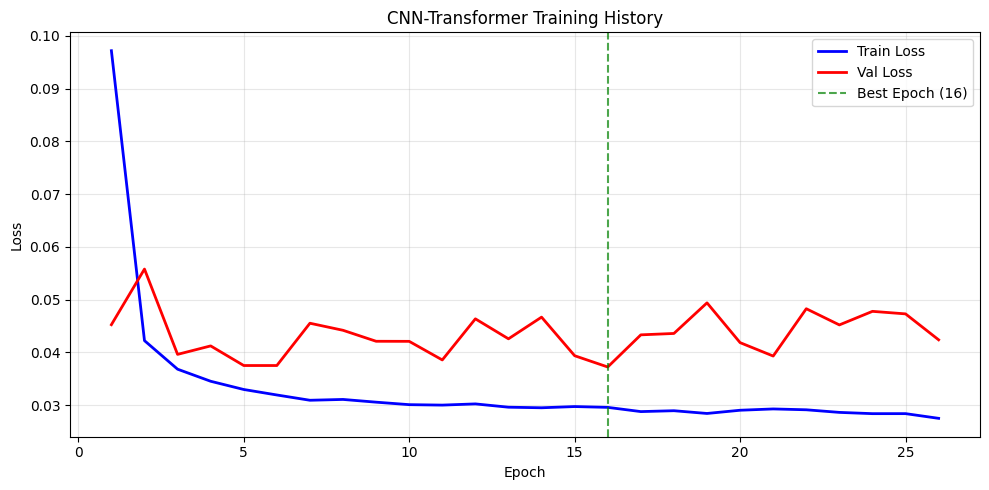

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax.plot(history['epoch'], history['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'CNN-Transformer Training History{" - QUICK" if QUICK_MODE else ""}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'cnn_transformer_training_history{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

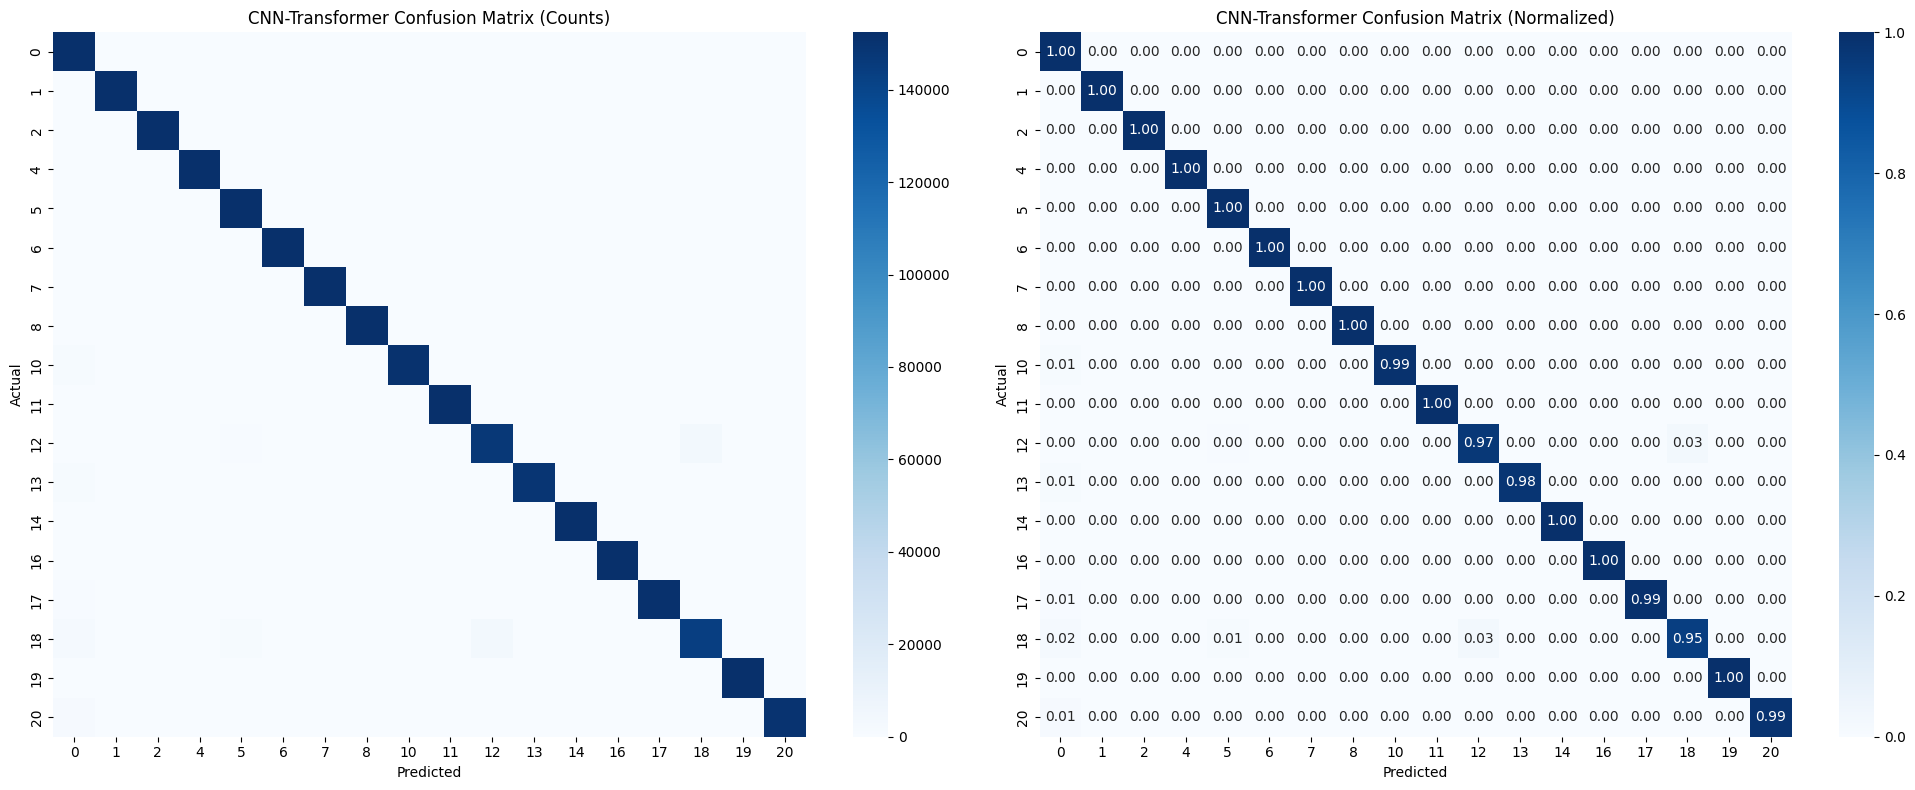

[2026-01-05 15:32:46] ✓ Saved confusion matrix to ../outputs/figures/cnn_transformer_confusion_matrix.png


In [10]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'CNN-Transformer Confusion Matrix (Counts){" - QUICK" if QUICK_MODE else ""}')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'CNN-Transformer Confusion Matrix (Normalized){" - QUICK" if QUICK_MODE else ""}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'cnn_transformer_confusion_matrix{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()
log(f"✓ Saved confusion matrix to {FIGURES_DIR / f'cnn_transformer_confusion_matrix{MODE_SUFFIX}.png'}")

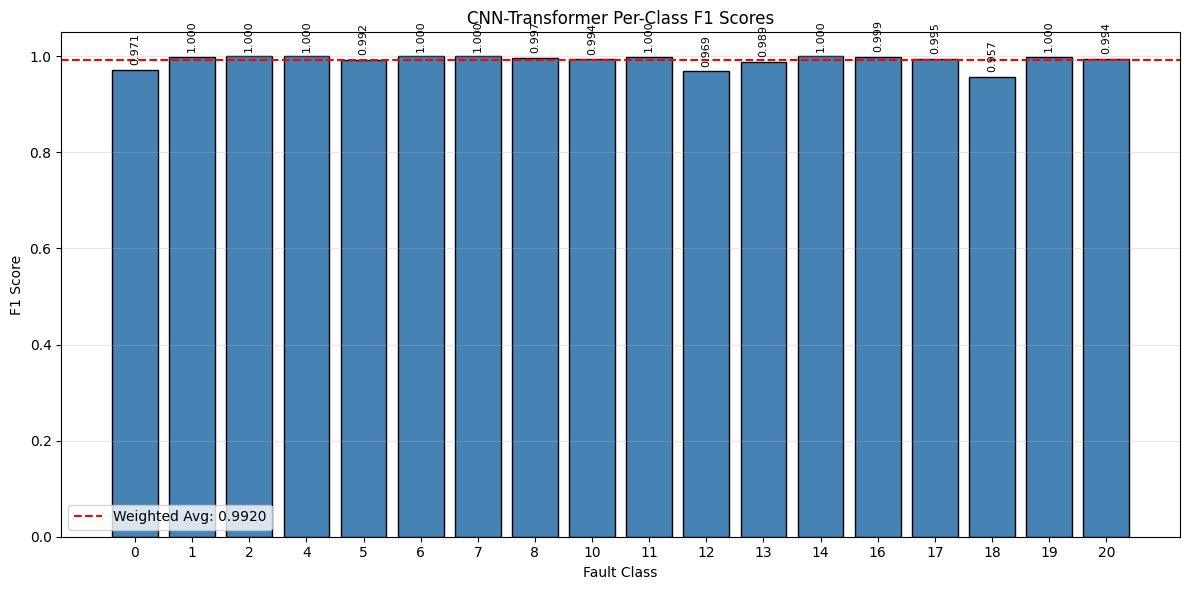

In [11]:
f1_per_class = f1_score(y_test, y_pred, average=None)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, f1_per_class, color='steelblue', edgecolor='black')
ax.axhline(y=f1_weighted, color='red', linestyle='--', label=f'Weighted Avg: {f1_weighted:.4f}')
ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title(f'CNN-Transformer Per-Class F1 Scores{" - QUICK" if QUICK_MODE else ""}')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, f1 in zip(bars, f1_per_class):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{f1:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'cnn_transformer_per_class_f1{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Results

In [12]:
end_time = time.time()
total_runtime = end_time - start_time

metrics = {
    'model': 'CNN-Transformer',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'train_fraction': TRAIN_FRACTION,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'best_epoch': best_epoch,
    'best_val_loss': float(best_val_loss),
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'hyperparameters': best_params,
    'epochs_trained': len(history['epoch']),
    'training_time_seconds': float(train_time),
    'total_runtime_seconds': float(total_runtime),
    'random_seed': RANDOM_SEED
}

with open(METRICS_DIR / f'cnn_transformer_metrics{MODE_SUFFIX}.json', 'w') as f:
    json.dump(metrics, f, indent=2)
log(f"✓ Saved metrics to {METRICS_DIR / f'cnn_transformer_metrics{MODE_SUFFIX}.json'}")

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_size': num_features,
        'conv_filters': best_params['conv_filters'],
        'kernel_size': best_params['kernel_size'],
        'd_model': best_params['d_model'],
        'nhead': best_params['nhead'],
        'num_encoder_layers': best_params['num_encoder_layers'],
        'dim_feedforward': best_params['dim_feedforward'],
        'dropout': best_params['dropout'],
        'num_classes': num_classes,
        'sequence_length': sequence_length
    },
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'label_encoder_classes': label_encoder.classes_.tolist(),
    'features': features
}, MODEL_DIR / f'cnn_transformer_final{MODE_SUFFIX}.pt')
log(f"✓ Saved model to {MODEL_DIR / f'cnn_transformer_final{MODE_SUFFIX}.pt'}")

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(METRICS_DIR / f'cnn_transformer_confusion_matrix{MODE_SUFFIX}.csv')
log(f"✓ Saved confusion matrix to {METRICS_DIR / f'cnn_transformer_confusion_matrix{MODE_SUFFIX}.csv'}")

print(f"\n{'='*60}")
log(f"✓ CNN-Transformer Final Training Complete! {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
log(f"Total runtime: {int(total_runtime // 60)}m {int(total_runtime % 60)}s")
log(f"Best epoch: {best_epoch}")
log(f"Test Accuracy: {accuracy:.4f}")
log(f"Test F1 (weighted): {f1_weighted:.4f}")
print(f"{'='*60}")

[2026-01-05 15:32:46] ✓ Saved metrics to ../outputs/metrics/cnn_transformer_metrics.json
[2026-01-05 15:32:46] ✓ Saved model to ../outputs/models/cnn_transformer_final.pt
[2026-01-05 15:32:46] ✓ Saved confusion matrix to ../outputs/metrics/cnn_transformer_confusion_matrix.csv

[2026-01-05 15:32:46] ✓ CNN-Transformer Final Training Complete! 
[2026-01-05 15:32:46] Total runtime: 69m 59s
[2026-01-05 15:32:46] Best epoch: 16
[2026-01-05 15:32:46] Test Accuracy: 0.9920
[2026-01-05 15:32:46] Test F1 (weighted): 0.9920
